# skFIBERS Datasim Experiments

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
from skfibers.fibers import FIBERS

In [2]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from skfibers.methods.fibers_methods import top_bin_summary_fibers

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Functions to Generate Dataset

In [4]:
def generate_features(row, number_of_features, number_of_features_in_bin, mm_frequency_range):
    mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    if row['TrueRiskGroup'] == 1:
        idxs = random.sample(list(range(1, number_of_features_in_bin + 1)), 
                             int(mm_frequency * number_of_features_in_bin))
        for idx in idxs:
            row['P_' + str(idx)] = 1
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    else:
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    return row

In [5]:
def censor(df, censoring_frequency):
#     df['Censoring'] = df['TrueRiskGroup']
    df['Censoring'] = 1
    inst_to_censor = int(censoring_frequency * len(df)) # len(df[df['TrueRiskGroup']==1]))
    max_duration = max(df['Duration'])
    df = df.sort_values('Duration')
    censor_count = 0
    while censor_count < inst_to_censor:
        for index in range(len(df)):
            prob = df['Duration'].iloc[index]/max_duration
            choice = np.random.choice([0, 1], 1, p=[prob, 1-prob])
            if choice == 0:
                censor_count +=1
                df['Censoring'].iloc[index] = choice
            if censor_count >= inst_to_censor:
                break
    return df

In [6]:
def create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(len(df_0), len(df_1)) * noise_frequency)
        idxs = random.sample(list(range(min(len(df_0), len(df_1)))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [7]:
def create_negative_control(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(no_fail_count, fail_count) * noise_frequency)
        idxs = random.sample(list(range(min(no_fail_count, fail_count))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [8]:
data = create_data_simulation_bin(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(1.7, 0.2), class1_time_to_event_range=(0.7, 0.2),
               censoring_frequency=0.5)

In [9]:
data.head(15)

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,R_34,R_35,R_36,R_37,R_38,R_39,R_40,TrueRiskGroup,Duration,Censoring
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,0,1.851186,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,1.774680,0
2,0,0,1,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0.512605,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,0,1.784930,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,1.670296,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2.037535,1
6,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1.852751,0
7,1,1,1,1,1,1,0,0,1,1,...,1,1,0,1,1,0,1,1,0.722776,1
8,1,0,1,1,0,0,0,1,1,1,...,1,0,1,0,0,1,0,1,0.917230,1
9,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0.513166,1


## Functions to Run Experiment

In [10]:
def experiment(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
               censoring_frequency=0.5, exp_str='1'):
    for replicate in range(0, 1):
        print('Experiment ' + exp_str)
        # Creating the simulated dataset with 1000 instances, 10 features to bin, 50 total features
        # no_fail_proportion=0.5, mm_frequency_range=(0.1, 0.5) , noise_frequency=0,
        # class0_time_to_event_range=(100, 200), class1_time_to_event_range=(20, 150)
        data = create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                                          no_fail_proportion, mm_frequency_range , noise_frequency,
                                          class0_time_to_event_range, class1_time_to_event_range,
                                          censoring_frequency)
        data = data.drop('TrueRiskGroup', axis=1)
        fibers = FIBERS(given_starting_point=False, amino_acid_start_point=None, algorithm="FIBERS",
                        amino_acid_bins_start_point=None, iterations=100, label_name="Censoring",
                        duration_name="Duration", rare_variant_maf_cutoff=0.2,
                        set_number_of_bins=50, min_features_per_group=2,
                        max_number_of_groups_with_feature=2,
                        scoring_method='Relief',
                        score_based_on_sample=True, score_with_common_variables=False,
                        instance_sample_size=50, crossover_probability=0.8,
                        mutation_probability=0.4, elitism_parameter=0.8,
                        random_seed=None, bin_size_variability_constraint=None)
        fibers.fit(data)
        fibers, bin_feature_matrix_internal, amino_acid_bins_internal, \
            amino_acid_bin_scores_internal, maf_0_features = fibers.transform(data)
        sorted_bin_scores = dict(sorted(amino_acid_bin_scores_internal.items(), key=lambda item: item[1], reverse=True))
        sorted_bin_list = list(sorted_bin_scores.keys())
        sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
        Bin = amino_acid_bins_internal[sorted_bin_list[0]]
        print("Best Bin:", Bin)
    return bin_feature_matrix_internal, amino_acid_bins_internal, \
        amino_acid_bin_scores_internal, maf_0_features

## Functions to plot outputs

In [11]:
def top_bin_summary_edited(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(durations_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(durations_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')
    plt.show()

In [12]:
def score_df(amino_acid_bin_scores_internal, amino_acid_bins_internal):
    amino_acid_bin_scores_internal_sorted = sorted(amino_acid_bin_scores_internal.items(), 
                                                   key=lambda x:x[1], reverse=True)
    amino_acid_bins_internal_sorted = sorted(amino_acid_bins_internal.items(), 
                                             key=lambda x:len(x[1]), reverse=True)
    tdf1 = pd.DataFrame(amino_acid_bin_scores_internal_sorted, columns=['Bin #', 'Score'])
    tdf2 = pd.DataFrame(amino_acid_bins_internal_sorted, columns=['Bin #', 'Bins'])
    tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
    display(tdf3.head(10).T)

## Testing Functions

In [13]:
bin_feature_matrix, amino_acid_bins, \
            amino_acid_bin_scores, maf_0_features = experiment(
                number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                no_fail_proportion=0.5, mm_frequency_range=(0.3, 0.4) , noise_frequency=0,
                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                censoring_frequency=0.5)

Experiment 1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Best Bin: ['P_9', 'P_4', 'P_7', 'P_10', 'P_8', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 39,Bin 23,Bin 9,Bin 24,Bin 28,Bin 4,Bin 30,Bin 25,Bin 27,Bin 36
Score,4474.931213,4068.186731,4031.250611,3743.814598,3671.636343,3664.837924,3555.787338,3130.217968,3082.593803,3029.987095
Bins,"[P_9, P_4, P_7, P_10, P_8, P_6]","[P_1, P_8, P_2, P_3, P_4]","[P_1, P_6, P_2, P_10, P_9]","[P_9, P_10, P_8, P_7]","[P_7, P_4, P_2, P_3]","[P_7, P_6, P_4, P_9]","[P_1, P_9, P_7, P_6]","[P_9, P_4, P_10]","[P_7, P_4, P_10]","[P_4, P_2, P_10]"


Bin of Amino Acid Positions:
['P_9', 'P_4', 'P_7', 'P_10', 'P_8', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5165
Number of Instances with Mismatch(es) in Bin:
4835
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        4474.93 <0.005       inf

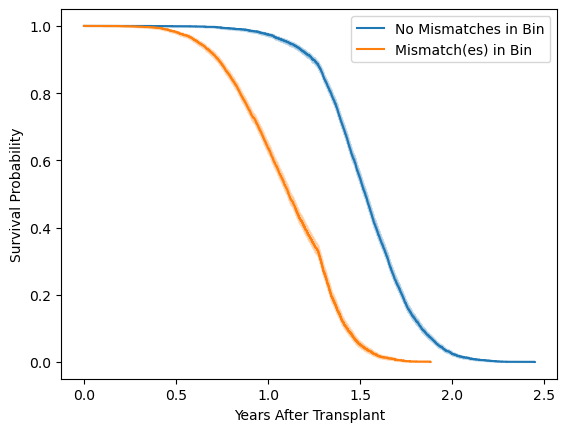

In [14]:
score_df(amino_acid_bin_scores, amino_acid_bins)
top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                           amino_acid_bin_scores)

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Best Bin: ['P_7', 'P_6', 'R_26', 'P_4', 'P_9', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 10,Bin 20,Bin 34,Bin 37,Bin 30,Bin 38,Bin 27,Bin 14,Bin 22,Bin 35
Score,341.465276,268.305006,265.063822,258.154267,245.451671,238.326193,211.185284,209.94802,199.579695,186.315761
Bins,"[P_7, P_6, R_26, P_4, P_9, P_3]","[P_6, P_9, P_8, R_20, P_2, P_3]","[P_5, P_7, R_33, P_10, P_2]","[P_7, P_6, P_8, R_33, P_10]","[P_7, P_6, P_4, P_3, R_12]","[P_6, P_2, P_3, P_4, R_17]","[P_7, P_6, P_4, R_28, P_3]","[P_4, P_3, R_15, P_9, P_7]","[P_6, P_8, P_7, P_10, R_21]","[R_24, P_3, P_7, P_8, P_2]"


Bin of Amino Acid Positions:
['P_7', 'P_6', 'R_26', 'P_4', 'P_9', 'P_3']
---
Number of Instances with No Mismatches in Bin:
7113
Number of Instances with Mismatch(es) in Bin:
2887
---
p-value from Log Rank Test:
3.060283305679407e-76


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         341.47 <0.005    250.85

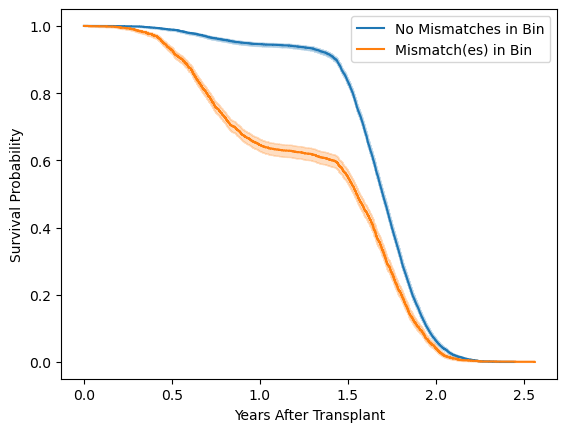

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Best Bin: ['P_1', 'P_2', 'P_10', 'P_4', 'P_7', 'R_15']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 12,Bin 14,Bin 27,Bin 2,Bin 19,Bin 16,Bin 33,Bin 39,Bin 32,Bin 3
Score,370.644661,343.66716,299.810385,295.00265,269.115058,229.694614,211.503275,192.208559,188.475654,186.206838
Bins,"[P_1, P_2, P_10, P_4, P_7, R_15]","[P_1, P_2, P_10, R_14, P_3]","[P_6, P_1, R_5, P_4, P_10]","[P_10, P_8, P_1, P_2, R_13]","[P_4, P_2, P_10, P_9, R_7]","[P_7, P_6, P_1, R_39, P_4]","[P_5, R_21, P_1, P_10]","[P_1, P_2, P_3, P_10, P_9, R_21, R_1]","[P_5, R_38, P_8, P_7]","[P_5, R_38, P_1, P_10]"


Bin of Amino Acid Positions:
['P_1', 'P_2', 'P_10', 'P_4', 'P_7', 'R_15']
---
Number of Instances with No Mismatches in Bin:
7140
Number of Instances with Mismatch(es) in Bin:
2860
---
p-value from Log Rank Test:
1.354664252784477e-82


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         370.64 <0.005    271.96

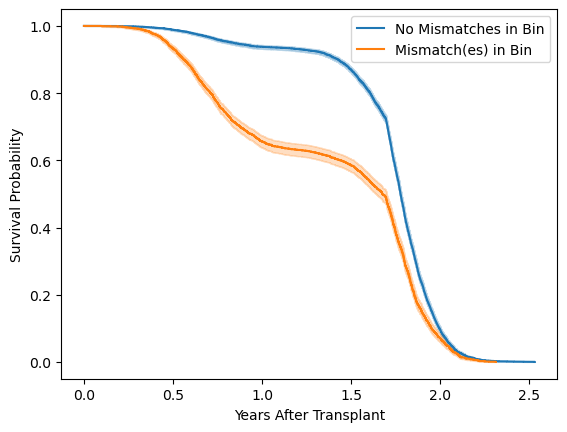

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


Best Bin: ['P_5', 'P_7', 'P_4', 'P_8', 'P_3', 'R_35']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 25,Bin 4,Bin 34,Bin 26,Bin 8,Bin 21,Bin 33,Bin 27,Bin 7
Score,518.307499,375.328995,370.349282,361.228758,354.024154,317.72698,251.56073,246.736889,244.742594,220.410204
Bins,"[P_5, P_7, P_4, P_8, P_3, R_35]","[P_7, P_6, P_5, P_2, R_24]","[P_1, P_5, P_3, R_2, P_7]","[P_7, P_6, P_1, P_2, P_3, P_10, P_9, R_36, R_32]","[P_5, P_9, R_9, P_1, P_7]","[P_5, R_12, P_3, P_8, P_4]","[P_5, P_7, P_1, P_6, R_33, R_8, P_3]","[P_7, R_18, P_6, P_4]","[P_10, P_5, R_37, P_1]","[P_7, P_2, R_36, P_3]"


Bin of Amino Acid Positions:
['P_5', 'P_7', 'P_4', 'P_8', 'P_3', 'R_35']
---
Number of Instances with No Mismatches in Bin:
7016
Number of Instances with Mismatch(es) in Bin:
2984
---
p-value from Log Rank Test:
9.880274437058494e-115


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         518.31 <0.005    378.72

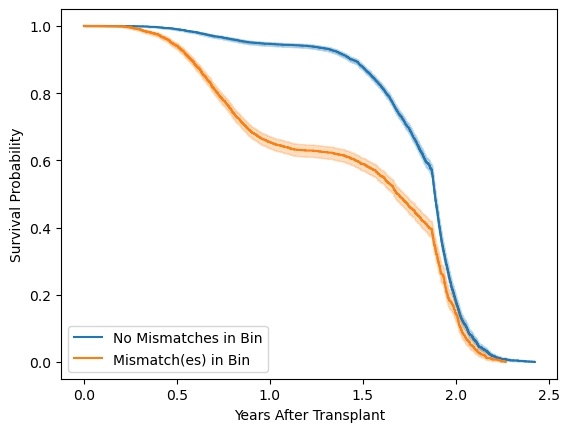

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Best Bin: ['P_7', 'P_6', 'P_4', 'R_14', 'P_3', 'P_8', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 20,Bin 38,Bin 26,Bin 1,Bin 6,Bin 30,Bin 5,Bin 36,Bin 7,Bin 39
Score,591.134631,563.472984,293.378287,261.800176,248.000257,235.994518,215.262189,210.793511,206.877319,206.42555
Bins,"[P_7, P_6, P_4, R_14, P_3, P_8, P_9]","[P_5, P_6, P_8, P_3, P_9, P_7, R_37]","[P_6, P_4, P_8, P_3, R_9]","[P_5, R_13, P_6, P_8, P_4]","[P_1, R_8, P_6, P_8]","[R_8, P_3, P_7, P_1]","[P_1, R_8, P_4, P_6, P_8, R_23]","[P_5, P_6, R_15, P_3, R_15]","[P_7, P_8, P_3, R_14]","[P_5, P_8, P_2, P_3, R_20, P_9, R_16, P_6]"


Bin of Amino Acid Positions:
['P_7', 'P_6', 'P_4', 'R_14', 'P_3', 'P_8', 'P_9']
---
Number of Instances with No Mismatches in Bin:
6943
Number of Instances with Mismatch(es) in Bin:
3057
---
p-value from Log Rank Test:
1.419420921695095e-130


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         591.13 <0.005    431.35

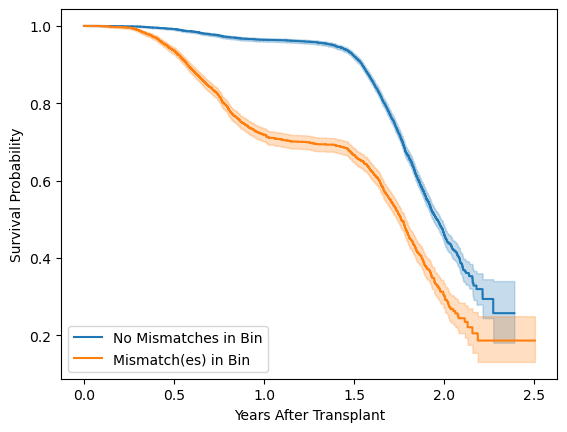

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


Best Bin: ['P_6', 'R_6', 'P_10', 'P_8', 'P_9', 'P_5']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 37,Bin 14,Bin 38,Bin 28,Bin 19,Bin 22,Bin 2,Bin 4,Bin 25,Bin 30
Score,512.567016,340.149756,277.670456,276.426822,262.85675,232.535389,229.913673,225.251475,221.079919,219.366244
Bins,"[P_6, R_6, P_10, P_8, P_9, P_5]","[P_6, R_13, P_1, P_10, P_5]","[P_5, P_8, P_3, P_9, P_10, R_35, R_24]","[P_7, P_1, P_6, R_24, P_8, R_35, P_9]","[P_5, R_5, R_8, P_2, P_3, P_9, P_8]","[P_2, P_3, P_7, R_23]","[P_3, R_34, P_10, P_5]","[P_7, R_8, R_7, P_8, P_3, P_6, P_9]","[P_7, P_6, P_2, R_5]","[P_7, R_37, P_1, R_37, P_8, P_8]"


Bin of Amino Acid Positions:
['P_6', 'R_6', 'P_10', 'P_8', 'P_9', 'P_5']
---
Number of Instances with No Mismatches in Bin:
7214
Number of Instances with Mismatch(es) in Bin:
2786
---
p-value from Log Rank Test:
1.7527029168202918e-113


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         512.57 <0.005    374.57

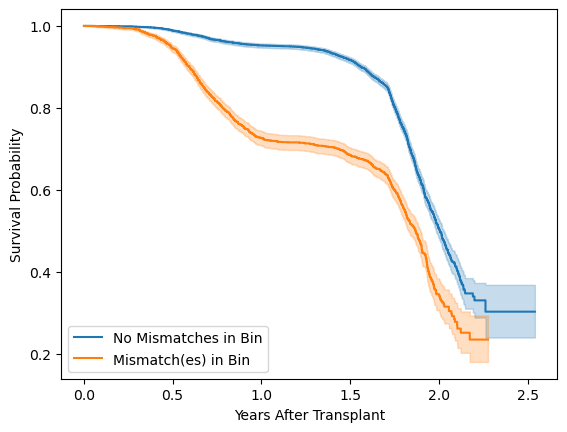

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Best Bin: ['P_7', 'P_8', 'R_17', 'P_3', 'P_9', 'P_4']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 11,Bin 25,Bin 40,Bin 24,Bin 32,Bin 18,Bin 23,Bin 39,Bin 8,Bin 38
Score,392.550652,366.973693,308.65472,289.810309,288.328299,281.853916,266.466383,259.305617,257.190385,253.213196
Bins,"[P_7, P_8, R_17, P_3, P_9, P_4]","[P_7, P_6, P_4, P_10, P_9, R_17]","[P_5, P_7, P_2, P_9, P_6, R_31]","[P_4, P_8, R_1, P_9, P_5]","[P_7, R_23, P_9, P_2, P_4]","[P_2, P_4, P_7, P_10, R_10]","[P_5, R_2, P_6, P_4, P_10]","[P_5, P_4, P_8, P_2, R_7]","[P_9, P_7, P_10, R_37, P_6]","[P_5, R_37, P_10, P_8, P_6]"


Bin of Amino Acid Positions:
['P_7', 'P_8', 'R_17', 'P_3', 'P_9', 'P_4']
---
Number of Instances with No Mismatches in Bin:
5915
Number of Instances with Mismatch(es) in Bin:
4085
---
p-value from Log Rank Test:
2.304632869349265e-87


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         392.55 <0.005    287.80

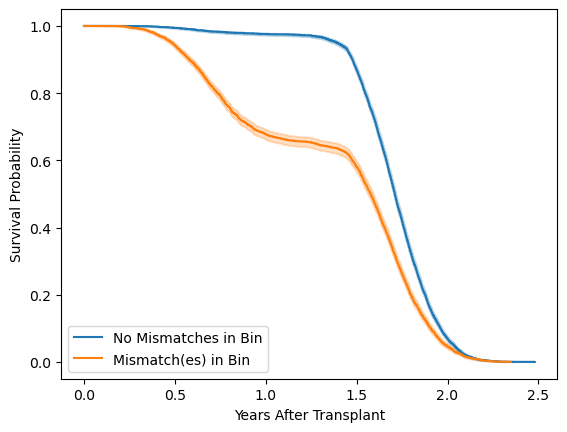

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Best Bin: ['P_1', 'P_3', 'R_20', 'P_5', 'P_4']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 23,Bin 10,Bin 29,Bin 19,Bin 15,Bin 5,Bin 31,Bin 40,Bin 3,Bin 22
Score,405.019602,369.699651,352.484504,349.026916,275.747829,274.203942,262.997122,259.246823,236.853689,231.756793
Bins,"[P_1, P_3, R_20, P_5, P_4]","[P_5, P_8, P_2, P_9, P_3, R_29]","[P_6, R_7, P_3, P_4, P_7]","[P_1, P_6, P_2, R_22, P_9]","[P_5, P_6, P_3, R_29, P_9]","[P_8, P_1, R_37, P_6]","[R_37, P_1, P_6, P_2]","[P_1, P_9, R_22, P_6]","[R_40, P_8, P_6, P_3]","[P_1, P_8, R_22, P_9]"


Bin of Amino Acid Positions:
['P_1', 'P_3', 'R_20', 'P_5', 'P_4']
---
Number of Instances with No Mismatches in Bin:
6101
Number of Instances with Mismatch(es) in Bin:
3899
---
p-value from Log Rank Test:
4.4488437455557515e-90


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         405.02 <0.005    296.82

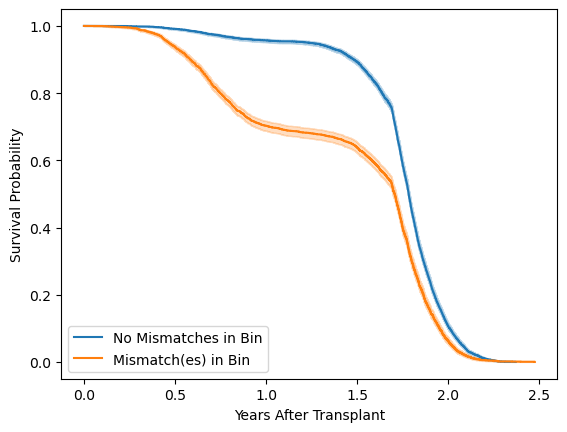

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Best Bin: ['P_5', 'P_4', 'P_8', 'P_10', 'R_29', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 32,Bin 35,Bin 29,Bin 15,Bin 13,Bin 26,Bin 28,Bin 14,Bin 5,Bin 21
Score,599.49264,520.135029,508.764139,480.37377,451.979516,436.792911,416.960365,345.159953,333.126974,331.375749
Bins,"[P_5, P_4, P_8, P_10, R_29, P_6]","[P_5, P_7, P_8, P_3, P_9, R_9]","[P_1, P_6, P_4, P_3, P_9, R_21]","[P_1, P_4, P_8, P_10, R_29]","[P_9, P_4, P_10, R_7, P_2]","[P_7, R_8, P_5, P_1, P_8]","[P_5, P_6, P_4, P_10, R_33]","[P_1, P_9, P_3, R_25]","[P_9, P_5, P_4, R_23]","[P_1, P_9, P_4, R_8]"


Bin of Amino Acid Positions:
['P_5', 'P_4', 'P_8', 'P_10', 'R_29', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5986
Number of Instances with Mismatch(es) in Bin:
4014
---
p-value from Log Rank Test:
2.158509002797547e-132


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         599.49 <0.005    437.38

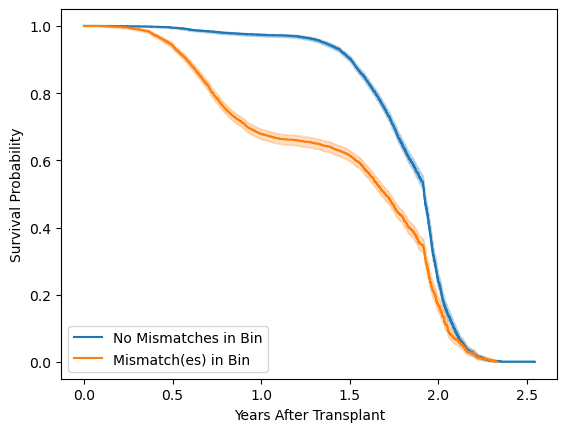

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Best Bin: ['P_2', 'P_4', 'P_7', 'P_10', 'P_3', 'R_36']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 11,Bin 8,Bin 17,Bin 34,Bin 39,Bin 4,Bin 40,Bin 2,Bin 38,Bin 28
Score,398.248625,387.287389,382.563697,369.671013,311.604578,309.881859,267.042427,261.565444,251.69944,229.111859
Bins,"[P_2, P_4, P_7, P_10, P_3, R_36]","[P_4, P_10, R_11, P_1, P_5, P_9]","[P_7, P_2, R_1, P_9, P_4]","[P_7, P_1, P_2, P_3, R_24]","[P_5, P_7, P_1, R_11, P_10]","[P_1, P_2, R_18, P_10, P_4]","[P_4, R_30, P_1, P_7]","[P_2, P_3, P_7, R_32]","[P_2, P_1, R_27, P_5]","[P_5, R_32, P_7, P_8]"


Bin of Amino Acid Positions:
['P_2', 'P_4', 'P_7', 'P_10', 'P_3', 'R_36']
---
Number of Instances with No Mismatches in Bin:
5853
Number of Instances with Mismatch(es) in Bin:
4147
---
p-value from Log Rank Test:
1.3249183672522378e-88


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         398.25 <0.005    291.92

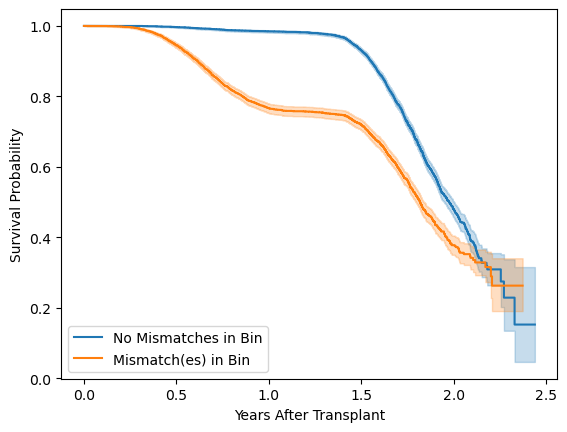

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Best Bin: ['P_6', 'P_4', 'P_8', 'P_2', 'P_10', 'P_3', 'R_31']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 29,Bin 24,Bin 9,Bin 39,Bin 40,Bin 37,Bin 36,Bin 26,Bin 1,Bin 34
Score,572.394454,522.316616,514.224012,479.001736,469.954588,467.263737,437.008612,403.329991,357.679948,332.887124
Bins,"[P_6, P_4, P_8, P_2, P_10, P_3, R_31]","[P_1, P_4, P_8, P_2, R_39, P_3]","[P_4, P_8, P_10, R_27, P_9, P_2]","[P_6, P_8, P_2, P_10, P_9, R_3]","[P_5, P_4, P_10, P_9, P_6, R_34]","[P_9, P_4, P_2, R_8, P_5, P_3]","[P_2, P_3, P_10, P_9, R_39]","[P_4, P_8, P_2, P_10, R_27]","[P_7, P_10, R_3, P_5, P_4]","[P_6, P_2, P_9, R_29]"


Bin of Amino Acid Positions:
['P_6', 'P_4', 'P_8', 'P_2', 'P_10', 'P_3', 'R_31']
---
Number of Instances with No Mismatches in Bin:
5815
Number of Instances with Mismatch(es) in Bin:
4185
---
p-value from Log Rank Test:
1.6922338530467775e-126


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         572.39 <0.005    417.80

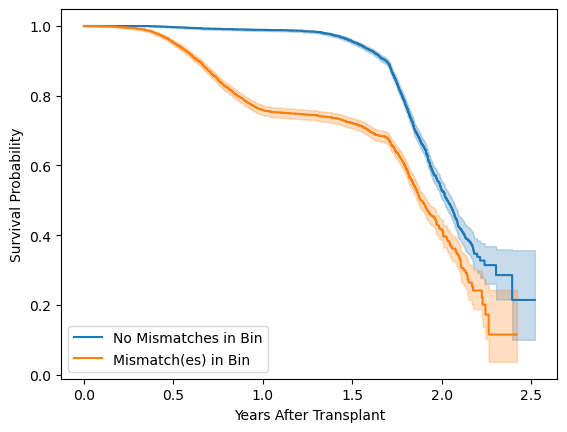

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Best Bin: ['P_7', 'P_4', 'R_14', 'P_9', 'P_10']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 37,Bin 9,Bin 14,Bin 21,Bin 15,Bin 26,Bin 45,Bin 13,Bin 5,Bin 12
Score,221.516655,207.471089,192.676943,187.322387,183.430915,172.420172,166.289444,160.064946,153.629337,140.510124
Bins,"[P_7, P_4, R_14, P_9, P_10]","[P_6, R_20, P_3, P_10, P_4]","[P_5, R_17, P_7, P_2]","[P_5, P_10, R_40, P_4, P_6]","[R_4, P_7, P_2, P_6]","[P_9, R_4, P_3, P_1]","[P_2, P_4, P_10, R_15]","[P_5, P_3, P_7, R_26]","[P_6, P_3, P_10, R_20]","[P_2, P_3, P_7, R_2]"


Bin of Amino Acid Positions:
['P_7', 'P_4', 'R_14', 'P_9', 'P_10']
---
Number of Instances with No Mismatches in Bin:
4989
Number of Instances with Mismatch(es) in Bin:
5011
---
p-value from Log Rank Test:
4.222478178184228e-50


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         221.52 <0.005    164.02

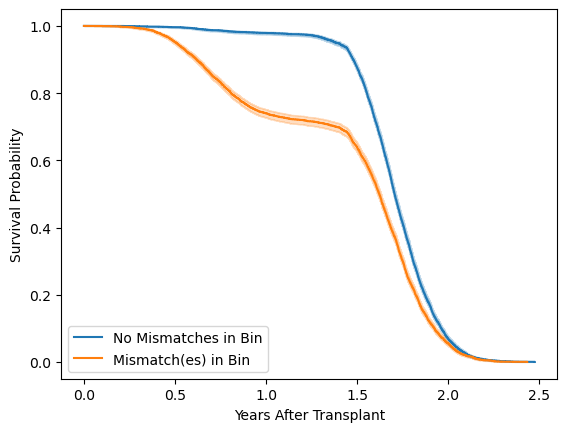

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Best Bin: ['P_5', 'P_3', 'P_9', 'R_7', 'P_1']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 11,Bin 26,Bin 3,Bin 12,Bin 28,Bin 17,Bin 29,Bin 24,Bin 34,Bin 36
Score,338.397245,328.936713,325.909567,322.844346,319.054677,310.532792,295.143644,292.911008,288.659261,257.453734
Bins,"[P_5, P_3, P_9, R_7, P_1]","[P_3, P_10, P_9, P_1, P_2, R_31]","[R_37, P_8, P_2, P_10, P_9, P_3]","[P_1, P_10, P_9, P_3, P_4, R_1]","[P_6, P_5, R_16, P_1, P_9]","[P_8, P_2, R_1, P_3, P_10, P_4]","[P_2, P_9, P_4, P_8, P_1, R_39]","[P_2, R_3, P_7, P_4, P_9]","[P_5, R_31, P_7, P_4, P_9]","[R_27, P_4, P_3, P_9]"


Bin of Amino Acid Positions:
['P_5', 'P_3', 'P_9', 'R_7', 'P_1']
---
Number of Instances with No Mismatches in Bin:
5001
Number of Instances with Mismatch(es) in Bin:
4999
---
p-value from Log Rank Test:
1.4253599061708338e-75


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         338.40 <0.005    248.63

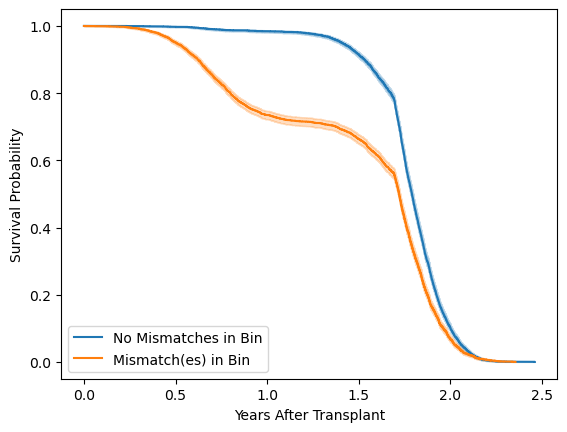

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Best Bin: ['P_5', 'R_21', 'P_10', 'P_4', 'P_8', 'P_8']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 40,Bin 39,Bin 28,Bin 10,Bin 16,Bin 2,Bin 23,Bin 15,Bin 32,Bin 37
Score,473.001864,465.1499,398.262175,393.655576,378.282734,378.222655,363.541518,320.211135,317.287516,314.22327
Bins,"[P_5, R_21, P_10, P_4, P_8, P_8]","[P_4, P_8, R_21, P_3, P_1]","[P_4, P_8, P_10, R_15, P_6]","[P_5, P_4, P_3, P_2, P_6, R_34]","[P_5, P_8, P_7, R_26, P_1]","[P_2, P_3, P_1, R_20]","[P_5, P_7, P_1, P_4, R_31]","[P_1, P_5, P_4, R_7]","[P_7, P_1, P_8, R_4]","[R_15, P_10, P_8, P_9]"


Bin of Amino Acid Positions:
['P_5', 'R_21', 'P_10', 'P_4', 'P_8', 'P_8']
---
Number of Instances with No Mismatches in Bin:
5026
Number of Instances with Mismatch(es) in Bin:
4974
---
p-value from Log Rank Test:
7.121073940611195e-105


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         473.00 <0.005    345.97

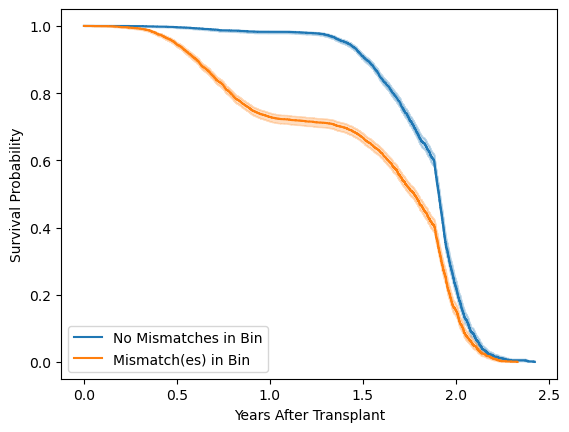

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


Best Bin: ['P_5', 'R_36', 'P_4', 'P_2', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 30,Bin 16,Bin 26,Bin 38,Bin 36,Bin 33,Bin 13,Bin 37,Bin 5
Score,288.946714,288.270785,255.97423,255.350311,234.53244,234.375259,225.856201,219.634857,183.843742,173.091005
Bins,"[P_5, R_36, P_4, P_2, P_6]","[P_5, R_5, P_4, P_2, P_9]","[R_4, P_8, P_4, P_10]","[P_2, R_13, P_3, P_4]","[P_5, P_1, P_2, R_2]","[P_5, P_8, P_2, R_23]","[P_1, P_8, P_2, R_33]","[P_5, P_4, P_2, R_36]","[P_2, P_5, P_3, R_25]","[P_5, R_16, P_2]"


Bin of Amino Acid Positions:
['P_5', 'R_36', 'P_4', 'P_2', 'P_6']
---
Number of Instances with No Mismatches in Bin:
5054
Number of Instances with Mismatch(es) in Bin:
4946
---
p-value from Log Rank Test:
8.434498391705808e-65


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         288.95 <0.005    212.85

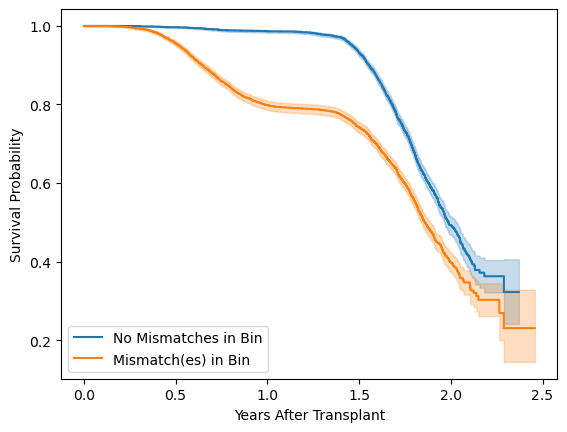

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Best Bin: ['P_5', 'P_1', 'P_8', 'P_2', 'P_3', 'R_21', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 18,Bin 4,Bin 10,Bin 25,Bin 29,Bin 3,Bin 12,Bin 7,Bin 30,Bin 2
Score,422.065994,400.902526,348.591065,337.534478,337.534478,333.502688,333.041137,311.776644,301.921978,297.125035
Bins,"[P_5, P_1, P_8, P_2, P_3, R_21, P_9]","[P_5, R_18, P_6, P_7, P_2]","[P_5, P_8, R_25, P_9]","[P_1, P_9, P_2, R_10]","[P_2, R_10, P_1, P_9]","[R_29, P_8, P_3, P_6, P_1]","[P_1, P_3, R_22, P_5]","[P_1, P_8, P_2, R_20, P_3]","[P_1, P_9, R_36, P_2]","[P_2, P_5, P_3, R_1]"


Bin of Amino Acid Positions:
['P_5', 'P_1', 'P_8', 'P_2', 'P_3', 'R_21', 'P_9']
---
Number of Instances with No Mismatches in Bin:
5022
Number of Instances with Mismatch(es) in Bin:
4978
---
p-value from Log Rank Test:
8.664846695596191e-94


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         422.07 <0.005    309.15

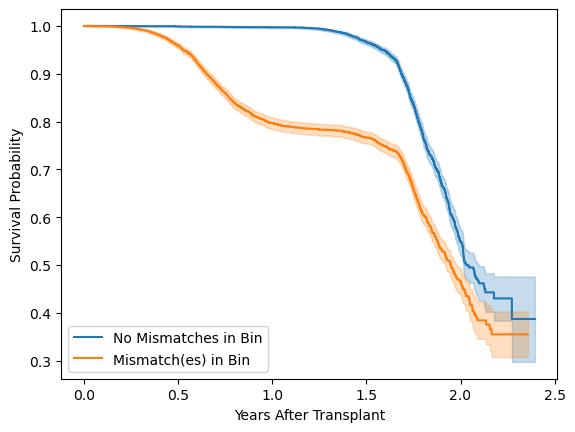

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['P_5', 'P_1', 'P_4', 'P_8', 'P_3', 'P_9', 'R_19']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 39,Bin 25,Bin 4,Bin 22,Bin 40,Bin 34,Bin 26,Bin 14,Bin 30,Bin 16
Score,201.751021,175.472627,174.829381,166.307917,164.0889,163.964808,161.320931,151.242722,148.968716,147.161729
Bins,"[P_5, P_1, P_4, P_8, P_3, P_9, R_19]","[P_2, P_10, P_8, R_7]","[P_8, P_5, P_9, R_21]","[P_6, P_4, P_8, P_2, R_23]","[P_1, P_4, P_2, R_10, P_9]","[R_26, P_4, P_8, P_3, P_1]","[P_4, P_8, P_2, P_7, P_10, R_16]","[P_4, P_2, P_9, R_31, P_6]","[R_18, P_8, P_9, P_3]","[P_4, P_2, R_11, P_6]"


Bin of Amino Acid Positions:
['P_5', 'P_1', 'P_4', 'P_8', 'P_3', 'P_9', 'R_19']
---
Number of Instances with No Mismatches in Bin:
4093
Number of Instances with Mismatch(es) in Bin:
5907
---
p-value from Log Rank Test:
8.664193586971067e-46


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         201.75 <0.005    149.69

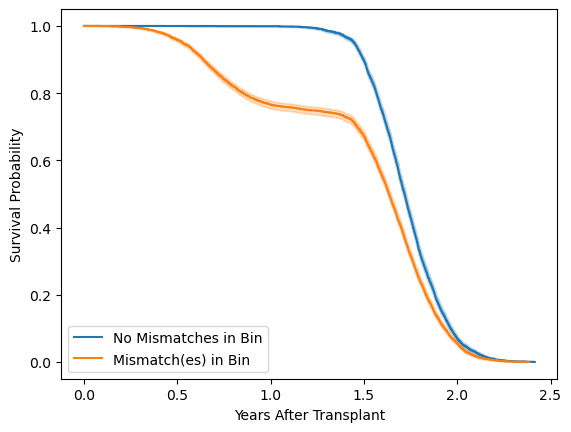

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['R_13', 'P_3', 'P_9', 'P_8']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 40,Bin 24,Bin 23,Bin 6,Bin 15,Bin 38,Bin 19,Bin 21,Bin 5,Bin 9
Score,240.750453,240.671474,235.357296,229.550424,228.836122,208.621263,204.148029,202.325769,200.647823,198.901576
Bins,"[R_13, P_3, P_9, P_8]","[P_5, P_6, P_8, P_2, P_9, R_22, P_3]","[P_1, R_13, P_3, P_10]","[P_1, P_5, R_13, P_10]","[P_5, P_6, R_7, P_8, P_2, P_3]","[P_5, P_1, R_25, P_9]","[P_5, P_1, R_24, P_2]","[P_1, R_20, P_3, P_6]","[P_5, P_2, P_1, R_36, P_8]","[P_5, P_8, P_9, R_33]"


Bin of Amino Acid Positions:
['R_13', 'P_3', 'P_9', 'P_8']
---
Number of Instances with No Mismatches in Bin:
4276
Number of Instances with Mismatch(es) in Bin:
5724
---
p-value from Log Rank Test:
2.6982013246072413e-54


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         240.75 <0.005    177.95

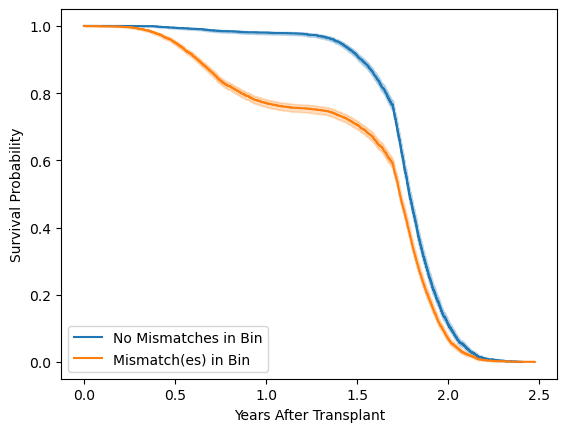

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:29<00:00,  1.11it/s]


Best Bin: ['P_7', 'P_8', 'R_9', 'P_5', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 14,Bin 27,Bin 38,Bin 40,Bin 15,Bin 16,Bin 33,Bin 32,Bin 29,Bin 21
Score,338.926448,335.694695,334.05438,331.709681,311.633237,311.437646,309.431327,308.714186,308.607612,305.299106
Bins,"[P_7, P_8, R_9, P_5, P_9]","[P_7, R_35, P_8, P_9, P_10, P_3]","[P_5, P_8, P_3, P_9, P_10, R_38]","[P_7, P_8, P_2, P_10, R_4]","[P_1, P_4, P_10, P_9, R_39]","[P_5, R_34, P_8, P_9]","[P_6, R_10, P_4, P_8, P_5]","[R_35, P_3, P_10, P_9, P_6]","[R_34, P_7, P_6, P_2]","[P_1, R_23, P_7, P_8]"


Bin of Amino Acid Positions:
['P_7', 'P_8', 'R_9', 'P_5', 'P_9']
---
Number of Instances with No Mismatches in Bin:
4140
Number of Instances with Mismatch(es) in Bin:
5860
---
p-value from Log Rank Test:
1.0931307544687397e-75


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         338.93 <0.005    249.02

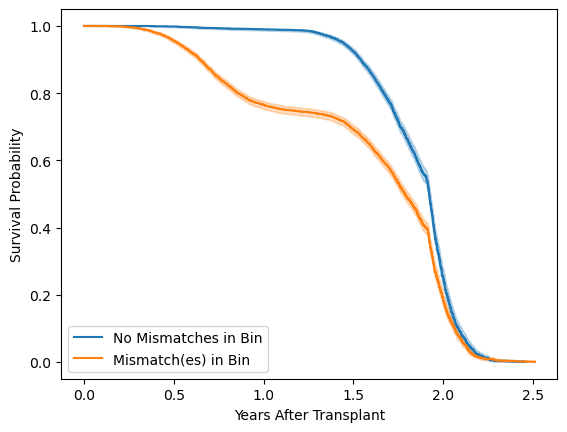

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Best Bin: ['P_6', 'P_8', 'P_2', 'P_3', 'P_7', 'R_28']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 47,Bin 30,Bin 35,Bin 19,Bin 36,Bin 6,Bin 27,Bin 37,Bin 31,Bin 23
Score,304.995173,268.156207,265.998883,265.125259,260.848656,249.870284,228.513829,224.64742,223.200613,211.908176
Bins,"[P_6, P_8, P_2, P_3, P_7, R_28]","[P_1, P_7, P_2, R_15, P_3]","[P_7, P_1, P_8, P_2, R_15]","[P_5, P_7, P_6, P_10, R_2, P_2]","[P_5, P_7, P_8, P_10, R_17]","[P_6, P_10, P_1, P_2, R_19]","[P_7, P_4, P_3, P_8, R_24]","[P_4, R_31, P_5, P_2, P_6]","[P_6, P_8, P_2, P_3, R_12]","[P_5, P_7, P_6, R_21]"


Bin of Amino Acid Positions:
['P_6', 'P_8', 'P_2', 'P_3', 'P_7', 'R_28']
---
Number of Instances with No Mismatches in Bin:
4069
Number of Instances with Mismatch(es) in Bin:
5931
---
p-value from Log Rank Test:
2.68856671056327e-68


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         305.00 <0.005    224.46

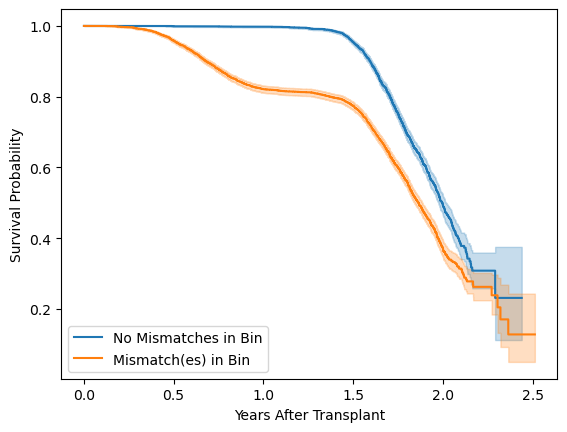

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Best Bin: ['P_5', 'P_6', 'P_4', 'P_2', 'P_3', 'R_27']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 30,Bin 41,Bin 25,Bin 15,Bin 29,Bin 27,Bin 31,Bin 17,Bin 36,Bin 26
Score,359.667901,342.924599,338.78942,336.046148,329.045434,323.088947,322.054448,313.431034,308.806244,305.937753
Bins,"[P_5, P_6, P_4, P_2, P_3, R_27]","[P_1, P_2, P_3, P_10, P_9, R_8, P_5]","[P_7, P_2, R_27, P_6, P_4]","[P_6, P_4, P_3, R_40, P_5]","[P_2, P_1, P_7, R_40, P_9]","[P_5, P_7, P_4, P_2, R_27]","[P_5, R_8, P_8, P_2, P_3]","[P_5, P_7, P_6, P_4, P_1, R_21]","[P_6, P_4, R_35, P_2]","[P_6, R_35, P_8, P_4]"


Bin of Amino Acid Positions:
['P_5', 'P_6', 'P_4', 'P_2', 'P_3', 'R_27']
---
Number of Instances with No Mismatches in Bin:
4160
Number of Instances with Mismatch(es) in Bin:
5840
---
p-value from Log Rank Test:
3.325811933655414e-80


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         359.67 <0.005    264.02

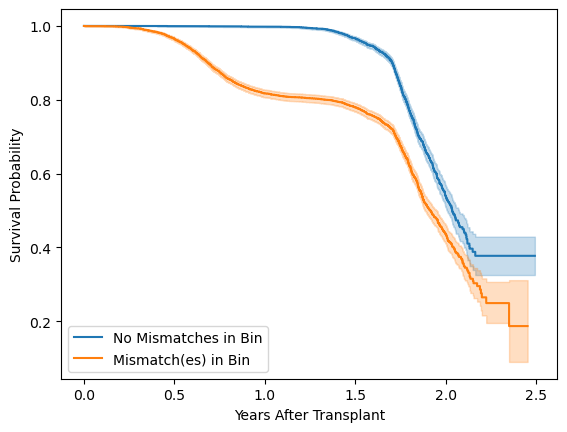

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Best Bin: ['P_7', 'P_10', 'R_31', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 32,Bin 12,Bin 22,Bin 28,Bin 37,Bin 40,Bin 29,Bin 39,Bin 4,Bin 36
Score,154.643485,151.158113,135.453908,127.858233,122.043896,121.126955,114.149661,113.362643,112.818105,111.887656
Bins,"[P_7, P_10, R_31, P_9]","[R_1, P_4, P_10, P_5]","[P_4, P_7, P_6, R_37]","[P_4, P_7, P_10, R_29]","[P_2, P_5, R_10, P_9]","[P_5, P_7, R_5]","[P_5, R_33, P_10, P_1]","[P_2, P_5, R_1]","[P_5, R_33, P_10, P_2]","[P_5, P_4, R_28]"


Bin of Amino Acid Positions:
['P_7', 'P_10', 'R_31', 'P_9']
---
Number of Instances with No Mismatches in Bin:
3419
Number of Instances with Mismatch(es) in Bin:
6581
---
p-value from Log Rank Test:
1.6753431888358136e-35


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         154.64 <0.005    115.52

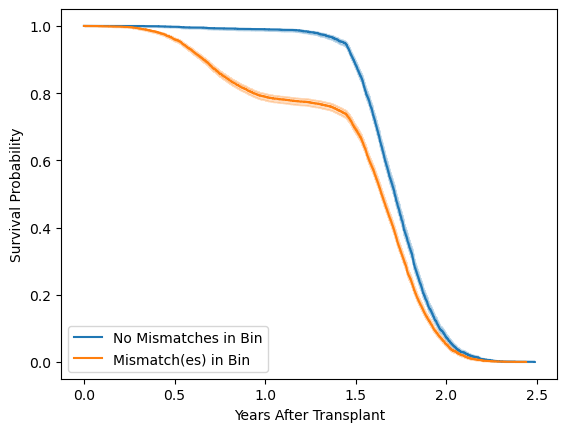

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Best Bin: ['P_5', 'P_7', 'P_4', 'P_8', 'P_3', 'R_15', 'P_6']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 34,Bin 35,Bin 18,Bin 33,Bin 27,Bin 16,Bin 12,Bin 39,Bin 26,Bin 3
Score,184.100887,178.160963,170.243425,168.479526,167.557571,163.590326,162.755625,161.922223,156.418603,153.319322
Bins,"[P_5, P_7, P_4, P_8, P_3, R_15, P_6]","[P_6, P_4, R_27, P_9, P_7]","[P_5, P_4, R_16]","[P_5, P_7, R_5, P_2, P_4]","[P_5, R_16, P_3]","[P_7, P_2, P_3, R_15]","[P_3, P_7, R_15, P_8]","[P_2, P_3, R_27, P_9]","[P_2, P_5, P_3, R_31]","[P_9, P_3, R_28]"


Bin of Amino Acid Positions:
['P_5', 'P_7', 'P_4', 'P_8', 'P_3', 'R_15', 'P_6']
---
Number of Instances with No Mismatches in Bin:
3294
Number of Instances with Mismatch(es) in Bin:
6706
---
p-value from Log Rank Test:
6.16715052134842e-42


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         184.10 <0.005    136.90

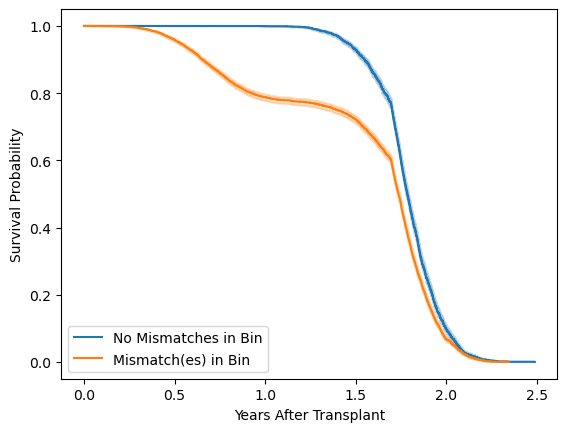

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


Best Bin: ['P_6', 'P_1', 'P_4', 'R_39', 'P_5', 'P_3', 'P_5']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 27,Bin 25,Bin 17,Bin 29,Bin 43,Bin 40,Bin 39,Bin 10,Bin 13,Bin 9
Score,252.892888,252.399468,246.902501,236.721352,236.292724,229.864003,219.929407,211.449687,204.369671,203.122965
Bins,"[P_6, P_1, P_4, R_39, P_5, P_3, P_5]","[P_1, P_4, P_2, P_3, R_8]","[P_9, P_3, R_18, P_5]","[P_1, P_2, P_3, R_18]","[P_6, P_3, P_7, R_18]","[P_9, P_10, P_6, R_8]","[P_4, P_8, P_2, P_5, R_24]","[P_5, P_8, R_33, P_9]","[P_2, P_5, P_9, P_1, R_3]","[P_2, R_21, P_1, P_9]"


Bin of Amino Acid Positions:
['P_6', 'P_1', 'P_4', 'R_39', 'P_5', 'P_3', 'P_5']
---
Number of Instances with No Mismatches in Bin:
3349
Number of Instances with Mismatch(es) in Bin:
6651
---
p-value from Log Rank Test:
6.078244284762287e-57


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         252.89 <0.005    186.75

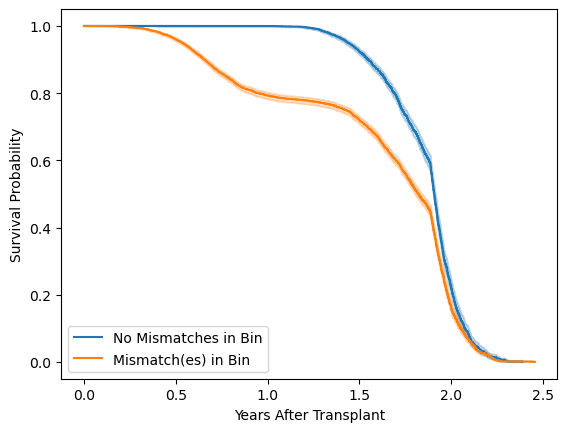

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


Best Bin: ['P_2', 'P_10', 'P_9', 'P_6', 'R_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 21,Bin 10,Bin 38,Bin 40,Bin 35,Bin 5,Bin 29,Bin 26,Bin 34,Bin 30
Score,183.258461,180.275763,169.169927,168.324829,168.245822,167.059556,165.53227,160.911254,157.880387,156.390374
Bins,"[P_2, P_10, P_9, P_6, R_3]","[P_1, P_4, R_11, P_8]","[P_2, R_33, P_10, P_4, P_5]","[R_33, P_9, P_3, P_8, P_2]","[P_2, P_9, P_1, R_40]","[P_5, P_6, R_22, P_4, P_7]","[P_8, P_2, P_3, R_22, P_4]","[P_4, P_8, P_2, R_35]","[R_33, P_10, P_9, P_8]","[P_8, P_2, R_29]"


Bin of Amino Acid Positions:
['P_2', 'P_10', 'P_9', 'P_6', 'R_3']
---
Number of Instances with No Mismatches in Bin:
3323
Number of Instances with Mismatch(es) in Bin:
6677
---
p-value from Log Rank Test:
9.418908412292201e-42


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         183.26 <0.005    136.29

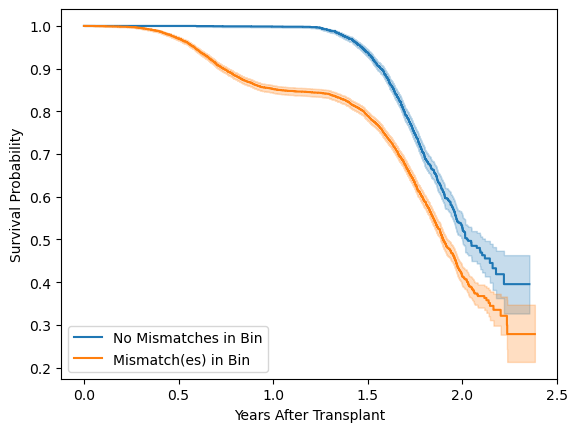

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Best Bin: ['P_9', 'P_10', 'P_1', 'P_5', 'P_4', 'R_8']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 5,Bin 34,Bin 8,Bin 39,Bin 36,Bin 28,Bin 14,Bin 37,Bin 26,Bin 38
Score,239.100599,232.732346,232.619866,223.060685,214.461263,210.748887,208.674494,203.980194,200.759288,195.906448
Bins,"[P_9, P_10, P_1, P_5, P_4, R_8]","[P_7, P_4, P_3, P_9, R_23]","[R_16, P_4, P_9, P_6]","[P_5, P_1, P_6, P_9, R_36]","[P_5, R_32, P_4, P_6]","[P_2, R_8, P_8, P_9]","[P_2, P_8, R_39, P_10]","[R_32, P_7, P_1, P_4]","[R_25, P_4, P_6, P_9]","[P_10, P_9, P_4, P_7, R_10]"


Bin of Amino Acid Positions:
['P_9', 'P_10', 'P_1', 'P_5', 'P_4', 'R_8']
---
Number of Instances with No Mismatches in Bin:
3359
Number of Instances with Mismatch(es) in Bin:
6641
---
p-value from Log Rank Test:
6.177554184814984e-54


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         239.10 <0.005    176.76

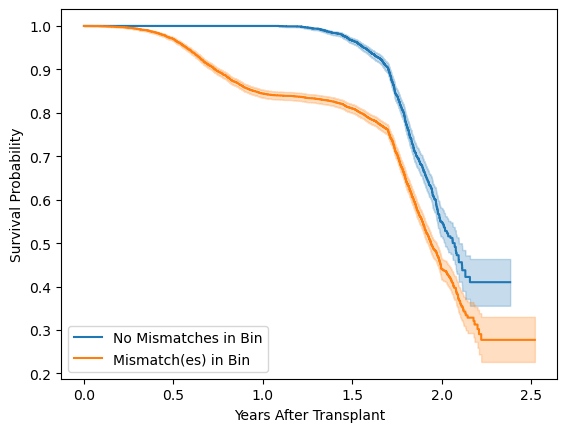

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


Best Bin: ['P_7', 'P_6', 'R_20', 'P_3', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 27,Bin 40,Bin 31,Bin 34,Bin 17,Bin 9,Bin 5,Bin 28,Bin 2,Bin 26
Score,114.167971,101.824094,95.481792,94.499232,92.654405,92.17789,92.044655,90.570523,87.458985,86.053974
Bins,"[P_7, P_6, R_20, P_3, P_3]","[P_6, P_8, R_20]","[P_6, P_2, R_33, P_3, P_9, P_7]","[P_1, P_3, R_20]","[P_1, P_3, R_35, P_5]","[P_1, R_33, P_8, P_9]","[R_33, P_9, P_2, P_3]","[P_1, P_8, R_35, P_3]","[P_7, P_1, R_28]","[P_6, R_28, P_2]"


Bin of Amino Acid Positions:
['P_7', 'P_6', 'R_20', 'P_3', 'P_3']
---
Number of Instances with No Mismatches in Bin:
2522
Number of Instances with Mismatch(es) in Bin:
7478
---
p-value from Log Rank Test:
1.1972473765803994e-26


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         114.17 <0.005     86.11

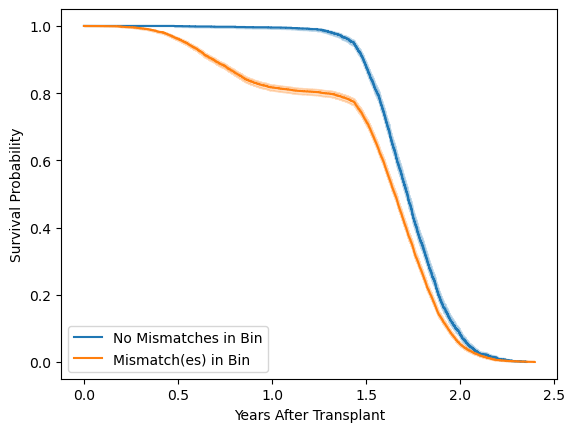

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


Best Bin: ['P_6', 'P_4', 'P_9', 'R_13']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 17,Bin 33,Bin 20,Bin 38,Bin 40,Bin 21,Bin 29,Bin 3,Bin 39,Bin 14
Score,133.790211,125.895345,119.341485,119.229313,117.63601,117.609242,117.215208,114.356514,113.413431,111.442663
Bins,"[P_6, P_4, P_9, R_13]","[P_5, P_7, R_10, P_9]","[P_6, P_4, P_8, R_7, P_1]","[P_7, P_8, P_9, R_33]","[P_4, P_3, P_6, R_30]","[P_6, P_1, P_9, R_7]","[P_7, P_8, P_9, R_18]","[P_5, P_6, R_28, P_10, P_4, P_7]","[P_5, P_7, P_4, R_28, P_9]","[P_6, R_5, P_4, P_3]"


Bin of Amino Acid Positions:
['P_6', 'P_4', 'P_9', 'R_13']
---
Number of Instances with No Mismatches in Bin:
2562
Number of Instances with Mismatch(es) in Bin:
7438
---
p-value from Log Rank Test:
6.07246639993752e-31


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         133.79 <0.005    100.38

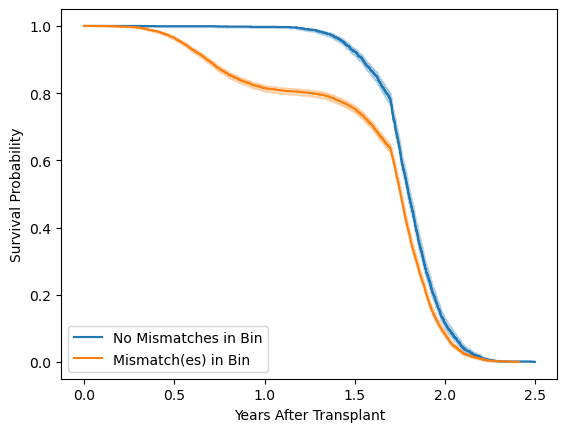

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Best Bin: ['R_31', 'P_4', 'P_10', 'P_7', 'P_9', 'P_5']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 35,Bin 29,Bin 6,Bin 32,Bin 5,Bin 1,Bin 10,Bin 30,Bin 40,Bin 13
Score,181.538786,180.837529,175.268477,171.404224,152.487153,151.682872,151.682872,151.480883,150.995902,150.410388
Bins,"[R_31, P_4, P_10, P_7, P_9, P_5]","[P_4, P_2, P_10, P_1, R_31]","[P_6, R_34, P_9, P_10]","[P_2, P_4, R_34, R_34, P_5]","[P_5, P_4, R_31]","[R_34, P_6, P_9]","[P_6, P_9, R_34]","[P_2, R_10, P_9, P_6]","[P_6, P_9, P_4, P_10, R_29]","[P_6, R_34, P_4]"


Bin of Amino Acid Positions:
['R_31', 'P_4', 'P_10', 'P_7', 'P_9', 'P_5']
---
Number of Instances with No Mismatches in Bin:
2486
Number of Instances with Mismatch(es) in Bin:
7514
---
p-value from Log Rank Test:
2.235881079985028e-41


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         181.54 <0.005    135.04

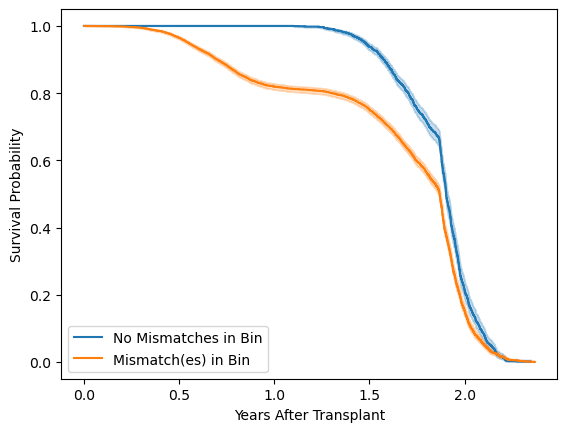

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Best Bin: ['P_2', 'P_5', 'P_8', 'P_1', 'R_38']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 18,Bin 36,Bin 25,Bin 34,Bin 11,Bin 7,Bin 39,Bin 12,Bin 37,Bin 23
Score,148.285067,133.974129,127.919856,124.865738,119.731205,118.091719,115.650935,112.682626,112.097865,111.104208
Bins,"[P_2, P_5, P_8, P_1, R_38]","[P_5, P_4, R_18, P_10]","[R_31, P_2, P_10, P_9]","[P_5, P_1, P_8, R_39]","[P_5, R_18, P_4]","[P_7, P_5, R_38]","[P_5, P_1, P_2, R_20]","[P_4, R_24, P_2, P_9]","[R_2, P_7, P_2, P_9, P_5]","[P_1, P_4, R_17, P_8]"


Bin of Amino Acid Positions:
['P_2', 'P_5', 'P_8', 'P_1', 'R_38']
---
Number of Instances with No Mismatches in Bin:
2565
Number of Instances with Mismatch(es) in Bin:
7435
---
p-value from Log Rank Test:
4.109766791359728e-34


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         148.29 <0.005    110.91

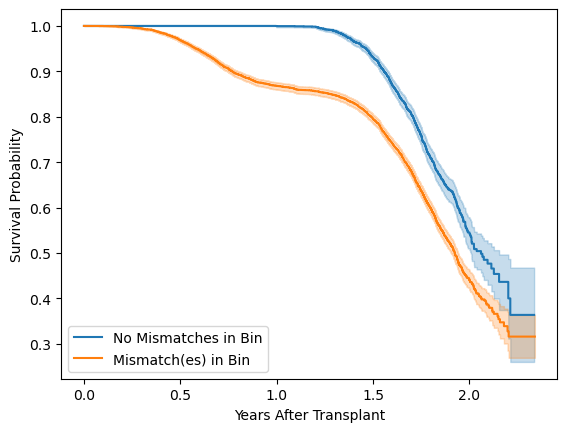

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['R_7', 'P_4', 'P_3', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 12,Bin 40,Bin 3,Bin 34,Bin 11,Bin 18,Bin 25,Bin 5,Bin 23,Bin 22
Score,167.892496,167.212867,167.159297,165.214963,161.278856,159.915781,159.027434,157.355215,156.703193,154.999076
Bins,"[R_7, P_4, P_3, P_9]","[P_1, P_2, P_9, R_12]","[R_34, P_3, P_6, P_4, P_9]","[R_7, P_3, P_9, P_2]","[P_4, R_18, P_3, P_9, P_6]","[P_2, P_1, R_8, P_3, P_9]","[P_5, P_6, R_34, P_3]","[R_19, P_7, P_3, P_1]","[P_6, P_4, P_2, P_3, R_40, P_7]","[P_3, P_10, P_5, R_34]"


Bin of Amino Acid Positions:
['R_7', 'P_4', 'P_3', 'P_9']
---
Number of Instances with No Mismatches in Bin:
2517
Number of Instances with Mismatch(es) in Bin:
7483
---
p-value from Log Rank Test:
2.1354181112973495e-38


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         167.89 <0.005    125.14

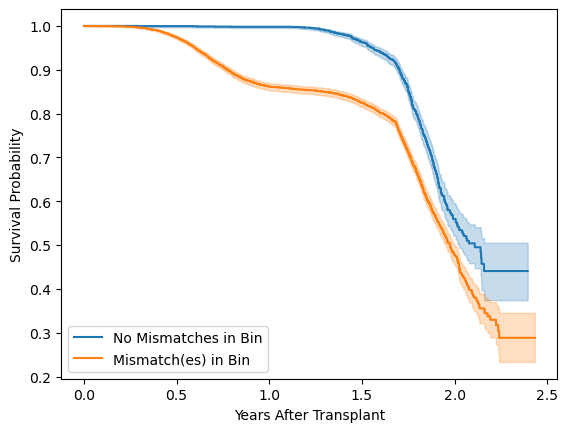

In [15]:
for i in range(1, 7):
    for j in range(1, 10, 2):
        bin_feature_matrix, amino_acid_bins, \
                amino_acid_bin_scores, maf_0_features = experiment(
            mm_frequency_range=(i/10, (i+2)/10) , 
            censoring_frequency=j/10, 
            exp_str="MM Freq Range=" + str((i/10, (i+2)/10)) + ", Censoring Freq="+str(j/10)
        )
        score_df(amino_acid_bin_scores, amino_acid_bins)
        top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                               amino_acid_bin_scores)